# Comparison between exploratory techniques on the example of 10-armed bandit

Import environment and necessary libraries.
Initialize rewards, total rewards, epsilon and episodes

In [1]:
import gym
import gym_n_bandit
import numpy as np
from math import e

%matplotlib inline
import matplotlib.pyplot as plt

random_reward_list = []
epsilon_reward_list = []
softmax_reward_list = []
ucb_reward_list = []
thompson_reward_list = []

random_action_list = np.zeros(10)
epsilon_action_list = np.zeros(10)
softmax_action_list = np.zeros(10)
ucb_action_list = np.zeros(10)
thompson_action_list = np.zeros(10)

random_total_reward = 0
epsilon_total_reward = 0
softmax_total_reward = 0
ucb_total_reward = 0
thompson_total_reward = 0

epsilon = 0.1
max_episodes = 1000
smoothening = 50

Random agent
$$a = random(0,b)$$

In [2]:
env = gym.make("NArmedBandit-v0")

table_q_r = np.zeros(env.action_space.n)
table_n = np.ones(env.action_space.n)

for episode in np.arange(max_episodes):
    env.reset()
    action = env.action_space.sample()
    _, reward, _, _ = env.step(action)
    table_q_r[action] = table_q_r[action] + (reward-table_q_r[action])/table_n[action]
    table_n[action]+=1
    
    random_action_list[action]+=1;
    random_reward_list.append((episode, reward))
    random_total_reward+=reward

Epsilon greedy exploration:<br>

with probability epsilon :
$$a = random(0, b)$$
with probability 1-epsilon:
$$a = argmax_aQ(a)$$

In [3]:
table_q_e = np.zeros(env.action_space.n)
table_n = np.ones(env.action_space.n)

for episode in np.arange(max_episodes):
    env.reset()
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(table_q_e)
    _, reward, _, _ = env.step(action)
    table_q_e[action] = table_q_e[action] + (reward-table_q_e[action])/table_n[action]
    table_n[action]+=1
    
    epsilon_action_list[action]+=1;
    epsilon_reward_list.append((episode, reward))
    epsilon_total_reward +=reward

Softmax agent<br>
Choose action randomly from a probability distribution:
$$ P(a) = \dfrac{e^{Q(a)}}{\sum_{a^\prime=0}^{a^\prime=b}e^{Q(a^\prime)}}$$


In [4]:
table_q_s = np.zeros(env.action_space.n)
table_n = np.ones(env.action_space.n)

for episode in np.arange(max_episodes):
    env.reset()
    probabilities = np.exp(table_q_s)/(np.sum(np.exp(table_q_s),axis=0))
    action = np.random.choice(env.action_space.n, p=probabilities)
    _, reward, _, _ = env.step(action)
    table_q_s[action] = table_q_s[action] + (reward-table_q_s[action])/table_n[action]
    table_n[action]+=1
    
    softmax_action_list[action]+=1;
    softmax_reward_list.append((episode, reward))
    softmax_total_reward +=reward

UCB agent<br>
Each time an action is chosen by:
$$a = argmax_a(Q(a)+2\sqrt{\dfrac{\ln t}{N(a)}})$$

In [5]:
table_q_u = np.zeros(env.action_space.n)
table_n = np.ones(env.action_space.n)
table_ucb = np.zeros(env.action_space.n)

for episode in range(1,max_episodes):
    env.reset()
    table_ucb = table_q_u + 2*(np.sqrt((np.log(episode))/table_n))
    action = np.argmax(table_ucb)
    _, reward, _, _ = env.step(action)
    table_q_u[action] = table_q_u[action] + (reward-table_q_u[action])/table_n[action]
    table_n[action]+=1
    
    ucb_action_list[action]+=1;
    ucb_reward_list.append((episode, reward))
    ucb_total_reward +=reward

Thompson agent<br>
Each time an action is chosen by:
$$a = argmax_aBeta(\alpha_a,\beta_a)$$
with:<br>
$$\alpha_a=\alpha_a+1\quad\textrm{if}\quad r>0$$
$$\beta_a=\beta_a+1\quad\textrm{if}\quad r<=0$$

In [6]:
table_q_t = np.zeros(env.action_space.n)
table_n = np.ones(env.action_space.n)
alpha_a = np.ones(env.action_space.n)
beta_a = np.ones(env.action_space.n)

for episode in np.arange(max_episodes):
    env.reset()
    theta = np.random.beta(alpha_a+1,beta_a+1)
    action = np.argmax(theta)
    _, reward, _, _ = env.step(action)
    
    table_q_t[action] = table_q_t[action] + (reward-table_q_t[action])/table_n[action]
    table_n[action]+=1
    
    if reward>0:
        alpha_a[action]+=1
    else:
        beta_a[action]+=1
    
    thompson_action_list[action]+=1;
    thompson_reward_list.append((episode, reward))
    thompson_total_reward +=reward   

Visualize the data<br>
Graphs of average reward over 50 actions

Text(0,0.5,'Reward')

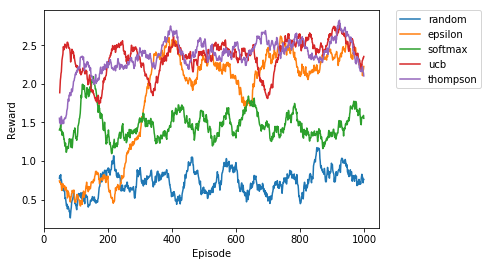

In [7]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

eps, rews = np.array(random_reward_list).T
random_smoothed_rews = running_mean(rews, smoothening)

eps, rews = np.array(epsilon_reward_list).T
epsilon_smoothed_rews = running_mean(rews, smoothening)

eps, rews = np.array(softmax_reward_list).T
softmax_smoothed_rews = running_mean(rews, smoothening)

eps, rews = np.array(ucb_reward_list).T
ucb_smoothed_rews = running_mean(rews, smoothening)

eps, rews = np.array(thompson_reward_list).T
thompson_smoothed_rews = running_mean(rews, smoothening)

plt.plot(eps[-len(random_smoothed_rews):], random_smoothed_rews, label='random')
plt.plot(eps[-len(epsilon_smoothed_rews):], epsilon_smoothed_rews, label='epsilon')
plt.plot(eps[-len(softmax_smoothed_rews):], softmax_smoothed_rews, label='softmax')
plt.plot(eps[-len(ucb_smoothed_rews):], ucb_smoothed_rews, label='ucb')
plt.plot(eps[-len(thompson_smoothed_rews):], thompson_smoothed_rews, label='thompson')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('Episode')
plt.ylabel('Reward')

Total rewards

In [8]:
print("Total rewards")
print('{:10} {:.3f}'.format("Random:", random_total_reward))
print('{:10} {:.3f}'.format("Epsilon:", epsilon_total_reward))
print('{:10} {:.3f}'.format("Softmax:", softmax_total_reward))
print('{:10} {:.3f}'.format("UCB:", ucb_total_reward))
print('{:10} {:.3f}'.format("Thompson:", thompson_total_reward))
print('{:10} {:.3f}'.format("Optimal:", max_episodes*env.getmax()))

Total rewards
Random:    731.869
Epsilon:   1830.238
Softmax:   1474.079
UCB:       2324.706
Thompson:  2340.988
Optimal:   2419.742


Approximated Q-values of each action

In [9]:
print("Q-value approximations:")
np.set_printoptions(precision=3)
print('{:10}'.format("Random:"),end=" ")
print(table_q_r)
print('{:10}'.format("Epsilon:"),end=" ")
print(table_q_e)
print('{:10}'.format("Softmax:"),end=" ")
print(table_q_s)
print('{:10}'.format("UCB:"),end=" ")
print(table_q_u)
print('{:10}'.format("Thompson:"),end=" ")
print(table_q_t)
env.render()

Q-value approximations:
Random:    [ 0.607  0.485  0.299  0.07  -0.692  1.364  0.511  2.357  1.501  0.975]
Epsilon:   [ 0.653  0.27   0.054  0.755 -0.902  1.271  0.072  2.456  1.218  0.776]
Softmax:   [ 0.573  0.575  0.468  0.037 -0.398  1.136  0.584  2.406  1.609  0.93 ]
UCB:       [-0.215  0.14  -0.04   0.641 -0.272  0.692  0.625  2.44   1.705  0.187]
Thompson:  [-0.111  0.774 -0.651 -0.56   0.916  0.     0.546  2.426  1.815  0.949]
True vals: [ 0.655  0.444  0.379 -0.054 -0.746  1.274  0.560  2.420  1.617  0.890 ]


Amount of action chosen

In [10]:
print("Actions chosen:")
print('{:10}'.format("Random:"),end=" ")
print(random_action_list)
print('{:10}'.format("Epsilon:"),end=" ")
print(epsilon_action_list)
print('{:10}'.format("Softmax:"),end=" ")
print(softmax_action_list)
print('{:10}'.format("UCB:"),end=" ")
print(ucb_action_list)
print('{:10}'.format("Thompson:"),end=" ")
print(thompson_action_list)

Actions chosen:
Random:    [ 99.  96.  97. 122.  99. 105.  94.  97.  95.  96.]
Epsilon:   [220.   8.   8.   8.  10.  87.   9. 636.   6.   8.]
Softmax:   [ 38.  52.  51.  40.  22. 101.  61. 377. 160.  98.]
UCB:       [  3.   5.   4.   8.   3.   7.   8. 923.  34.   4.]
Thompson:  [  1.   7.   1.   1.   1.   0.   6. 910.  64.   9.]
